#  Consider the following equation

Consider the following differential equation:

$$
\begin{aligned}
-\epsilon^2 U''(x) + U(x) &= 0 & x \text{ in } (0, 1), \\
U(0) &= 0, \\
U(1) &= k +  \int_{0}^{1} U^2(y) \, dy.
\end{aligned}
$$



In [ ]:
#!pip install pyDOE

In [ ]:
import torch
print('torch version = ', torch.__version__)
import torch.nn as nn

torch version =  2.2.1+cu121


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import random

from pyDOE import lhs

import numpy as np
from numpy.fft import fft,ifft,fftshift

#CUDA support
device = torch.device('cpu')
#device = torch.device('cuda:0')
print('device= ', device)

np.random.seed(1234) #生成指定隨機數
torch.set_default_dtype(torch.float64) #設置浮點類型


device=  cpu


In [ ]:
class Plain(nn.Module):

  def __init__(self, in_dim, h_dim , out_dim):
    super().__init__()
    self.ln1 = nn.Linear( in_dim , h_dim )
    self.act1 = nn.Sigmoid()
    self.ln2 = nn.Linear( h_dim , out_dim , bias = False )

  def forward(self, x):
    out = self.ln1(x)
    out = self.act1(out)
    out = self.ln2(out)
    return out


def count_parameters(model, requires_grad = True):
  """Count trainable parameters for a nn.Module."""
  if requires_grad:
      return sum(p.numel() for p in model.parameters() if p.requires_grad)
  return sum(p.numel() for p in model.parameters())

# **Boundary conditions**

$$
U(0) = 0 \text{ and, }U(1) = \text{k} + \int_{0}^{1}U^2(y)\text{d}y
$$

# **Loss function**

$$
\text{L} = λ_1 * \text{pde_loss} + λ_2 * (U(0)-0)^2 + λ_3 * (U(1) - \text{k} - \int_{0}^{1} U^2(y)\text{d}y
$$

$$
\text{pde_loss } = -ϵ^2  U''(x) + U(x)
$$
$$
λ_1,λ_2,λ_3 \text{  is weight}
$$

In [ ]:
def loss(model, X_inner ):
  #方程參數 ϵ = 10**(-1)
  e = 10**(-1)
  #e = 1
  #權重
  lambda_1=1.0
  lambda_2=1.0
  lambda_3=1.0
  inner_pred = model(X_inner)
  dudX = torch.autograd.grad(
      inner_pred, X_inner,
      grad_outputs=torch.ones_like(inner_pred),
      retain_graph=True,
      create_graph=True
  )[0]  #u_x and u_y =u'
  dudX_xX = torch.autograd.grad(
      dudX[:,0], X_inner,
      grad_outputs=torch.ones_like(dudX[:,0]),
      retain_graph=True,
      create_graph=True
  )[0]  #u_xx and u_yy =u''
  laplace = dudX_xX

  #先假設方程參數k = 1來看
  k = 0
  residual = -e**2 * laplace[:,0] + inner_pred.squeeze()
  inner_loss = lambda_1 * torch.mean(residual**2) #計算殘差平方和，及內部損失

  #邊界條件
  alpha = 0 #U(0)=α
  beta = k + torch.mean(inner_pred**2) #U(1)= β
  #beta = 40
  #beta = 600

  #計算邊界處的值
  u_0 = model(torch.tensor([[0.0]], device=device)) #U(0)
  u_1 = model(torch.tensor([[1.0]], device=device)) #U(1)

  #計算邊界損失
  boundary_loss = lambda_2 * (u_0 - alpha)**2 + lambda_3 * (u_1 - beta)**2

  #總損失
  loss = inner_loss +boundary_loss

  return loss , inner_pred


# **Exact solution**

$$
U(x) = Ae^{\frac{x}{\epsilon}} - Ae^{-\frac{x}{\epsilon}}
$$

$$
A_1 = \frac{2\sinh\left(\frac{1}{\epsilon}\right) + \sqrt{4\sinh^2\left(\frac{1}{\epsilon}\right) - 4k\epsilon \sinh\left(\frac{2}{\epsilon}\right) + 8k}}{2\epsilon \sinh\left(\frac{2}{\epsilon}\right) - 4}
\\
A_2 = \frac{2\sinh\left(\frac{1}{\epsilon}\right) - \sqrt{4\sinh^2\left(\frac{1}{\epsilon}\right) - 4k\epsilon \sinh\left(\frac{2}{\epsilon}\right) + 8k}}{2\epsilon \sinh\left(\frac{2}{\epsilon}\right) - 4}
$$
\
$$
\text{if } k = 0,
$$
$$
A = \begin{cases}
0, &  \\
\frac{2\sinh\left(\frac{1}{\epsilon}\right)}{\epsilon\sinh\left(\frac{2}{\epsilon}\right)-2}, & \text{otherwise}.
\end{cases}
$$


In [ ]:
def exact_u(x):
  #方程參數與上面相同
  e = 10**(-1)
  #e = 1
  k = 0
  # A_1 = np.sqrt(-(k - 2*np.sinh(1/e)) / (e * np.sinh(2/e) - 2))
  # A_1 = (np.sinh(1/e) + np.sqrt(np.sinh(1/e)**2 - k * e * np.sinh(2/e) + 2*k)) / (e * np.sinh(2/e) - 2)
  # A_2 = -np.sqrt(-(k - 2*np.sinh(1/e)) / (e * np.sinh(2/e) - 2))
  A_1 = (np.sinh(1/e) + np.sqrt(np.sinh(1/e)**2 - k * e * np.sinh(2/e) + 2*k)) / (e * np.sinh(2/e) - 2)
  A_2 = (np.sinh(1/e) - np.sqrt(np.sinh(1/e)**2 - k * e * np.sinh(2/e) + 2*k)) / (e * np.sinh(2/e) - 2)
  #計算精確解，先用A_1來試試看
  #eu = A_1 * (np.exp(x/e) - np.exp(-x/e))
  eu1 = 2 * A_1 * np.sinh(x/e)
  eu2 = 2 * A_2 * np.sinh(x/e)


  return eu1 , eu2

In [ ]:
  e = 10**(-1)
  k = 0
  # A_1 = np.sqrt(-(k - 2*np.sinh(1/e)) / (e * np.sinh(2/e) - 2))
  # print(np.exp(1/e))
  # print(np.sqrt(20) * np.exp(5))

  A_1 = (np.sinh(1/e) + np.sqrt(np.sinh(1/e)**2 - k * e * np.sinh(2/e) + 2*k)) / (e * np.sinh(2/e) - 2)
  A_2 = (2*np.sinh(1/e) + np.sqrt(4*np.sinh(1/e)**2 - 4*k * e * np.sinh(2/e) + 8*k)) / (2*e * np.sinh(2/e) - 4)
  A_3 = (2*np.sinh(1/e) - np.sqrt(4*np.sinh(1/e)**2 - 4*k * e * np.sinh(2/e) + 8*k)) / (2*e * np.sinh(2/e) - 4)
  A_4 = 2 * A_2 * np.sinh(1/e)
  print(A_4)
  print(A_2)
  print(A_3)

20.000001566476882
0.0009079986682391622
0.0


# **Training points**


In [ ]:
#number of grid points

N_training = 1000
X_training = lhs(1, N_training)

X_inner_torch = torch.from_numpy(X_training).requires_grad_(True).double().to(device)

# **Validation points**

In [ ]:
#validation set 驗證集
N_valid = N_training
X_valid = lhs(1, N_valid)

X_valid_inner_torch = torch.from_numpy(X_valid).requires_grad_(True).double().to(device)

# **The Network model**

In [ ]:
#神經網路隱藏層的神經元數量為...
N_neurons = 20

#single-layer model設置了一個單層神經網路模型
#輸入and 輸出 維度=1
model = Plain(1, N_neurons, 1).to(device)
print(model)
print(f"Number of paramters: {count_parameters(model)}")

Plain(
  (ln1): Linear(in_features=1, out_features=20, bias=True)
  (act1): Sigmoid()
  (ln2): Linear(in_features=20, out_features=1, bias=False)
)
Number of paramters: 60


# **Training with LBFGs optimizer**

In [ ]:
optimizerLBFGS = torch.optim.LBFGS(
    model.parameters(),
    lr=0.1, # 學習率
    max_iter=2000, #最大迭代次數
    max_eval=2000, #最大函數評估次數
    history_size=50, #更新 history_size 預設為100
    tolerance_grad=-np.finfo(float).eps,#一階最優性的終止容差（默認值：1e-5）;加(-)號可迭帶到最大迭帶次數，因為值不會小於要停止的值
    tolerance_change=-np.finfo(float).eps, #函數值/參數更改的終止容差（默認值：1e-9 ）; 同上
    line_search_fn="strong_wolfe"       # can be "strong_wolfe"
)

In [ ]:
def loss_func_lbfgs():

    optimizerLBFGS.zero_grad() # L-BFGS的基本思想是只保存最近的m次迭代信息，从而大大减少數據的儲存空間
    global itera
    itera += 1

    lossLBFGS = loss(model, X_inner_torch)[0]
    lossLBFGS_valid = loss(model, X_valid_inner_torch)[0]

    if itera % 200 == 0: # 一次迭代----
        print(
            'Iter %5d, LossLBFGS: %.5e, Loss_Valid: %.5e' % (itera, lossLBFGS.item(), lossLBFGS_valid.item())
            )

    savedloss.append(lossLBFGS.item())
    savedloss_valid.append(lossLBFGS_valid.item())

    lossLBFGS.backward(retain_graph = True)

    return lossLBFGS

In [ ]:
itera = 0

savedloss = []
savedloss_valid = []

In [ ]:
%%time

model.train()

lossLBFGS = loss(model, X_inner_torch)[0]
lossLBFGS_valid = loss(model, X_valid_inner_torch)[0]


print('Iter %5d, LossLBFGS: %.5e, Loss_Valid: %.5e' % (itera, lossLBFGS.item(), lossLBFGS_valid.item()))

savedloss.append(lossLBFGS.item())
savedloss_valid.append(lossLBFGS_valid.item())

# Backward and optimize
optimizerLBFGS.step(loss_func_lbfgs)

Iter  2001, LossLBFGS: 1.60093e+03, Loss_Valid: 1.60301e+03
Iter  2200, LossLBFGS: 4.21776e-04, Loss_Valid: 4.77798e-04
Iter  2400, LossLBFGS: 1.32178e-05, Loss_Valid: 5.62826e-05
Iter  2600, LossLBFGS: 3.22620e-06, Loss_Valid: 4.53751e-05
Iter  2800, LossLBFGS: 2.24583e-06, Loss_Valid: 4.55841e-05
Iter  3000, LossLBFGS: 1.59474e-06, Loss_Valid: 4.40548e-05
Iter  3200, LossLBFGS: 1.56178e-06, Loss_Valid: 4.36571e-05
Iter  3400, LossLBFGS: 1.56147e-06, Loss_Valid: 4.36573e-05
Iter  3600, LossLBFGS: 1.56130e-06, Loss_Valid: 4.36616e-05
Iter  3800, LossLBFGS: 1.56121e-06, Loss_Valid: 4.36581e-05
Iter  4000, LossLBFGS: 1.56115e-06, Loss_Valid: 4.36495e-05
CPU times: user 11.4 s, sys: 77.9 ms, total: 11.4 s
Wall time: 11.5 s


tensor([[1600.9300]], grad_fn=<AddBackward0>)

# **Plotting the evolution of loss**

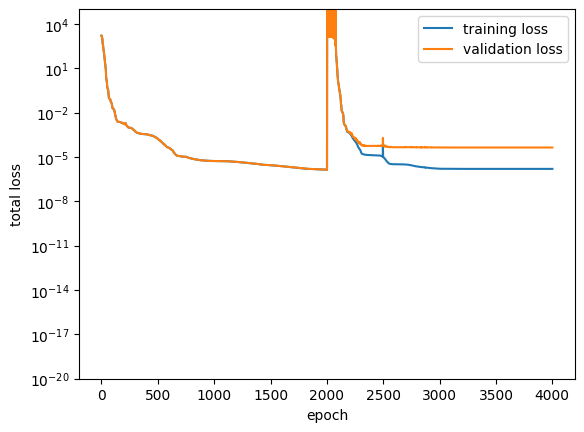

In [ ]:
start = 0
end = itera
idx = list(range(start, end, 1))

plt.figure()
plt.ylim(10**(-20), 10**5)
plt.yscale("log")
plt.plot(idx, savedloss[start:end], label = "training loss")
plt.plot(idx, savedloss_valid[start:end], label = "validation loss")
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.legend()
plt.show()

# **Plot error**

In [ ]:
# number of testing points
N_test = 1000

# Error at the interior points
x_test = lhs(1, N_test)
u_test1, u_test2 = exact_u(x_test)
#u_test = exact_u(x_test)


x_test_torch = torch.tensor(x_test).double().to(device)
u_pred = model(x_test_torch).detach().cpu().numpy()

print('error measure')
print()

#error = np.absolute(u_pred - u_test)
error1 = np.abs(u_pred - u_test1)
error2 = np.abs(u_pred - u_test2)

# error_u_inf_r = np.linalg.norm(error, np.inf)/np.linalg.norm(u_test, np.inf)
# print('Error u (relative inf-norm): %e' % (error_u_inf_r))
# error_u_2r = np.linalg.norm(error,2)/np.linalg.norm(u_test,2)
# print('Error u (relative 2-norm): %e' % (error_u_2r))
# error_u_inf = np.linalg.norm(error, np.inf)
# print('Error u (absolute inf-norm): %e' % (error_u_inf))
# error_u_2 = np.linalg.norm(error,2)/np.sqrt(N_test)
# print('Error u (absolute 2-norm): %e' % (error_u_2))

error measure



In [ ]:
# Calculate errors for each exact solution
error1 = np.abs(u_pred - u_test1)
error2 = np.abs(u_pred - u_test2)

# Calculate relative infinity norm error for each solution
error_u1_inf_r = np.linalg.norm(error1, np.inf) / np.linalg.norm(u_test1, np.inf)
error_u2_inf_r = np.linalg.norm(error2, np.inf) / np.linalg.norm(u_test2, np.inf)
# print('Error eu1 (relative inf-norm): %e' % error_u1_inf_r)
# print('Error eu2 (relative inf-norm): %e' % error_u2_inf_r)

# Calculate relative 2-norm error for each solution
error_u1_2r = np.linalg.norm(error1, 2) / np.linalg.norm(u_test1, 2)
error_u2_2r = np.linalg.norm(error2, 2) / np.linalg.norm(u_test2, 2)
# print('Error eu1 (relative 2-norm): %e' % error_u1_2r)
# print('Error eu2 (relative 2-norm): %e' % error_u2_2r)

# Calculate absolute infinity norm error for each solution
error_u1_inf = np.linalg.norm(error1, np.inf)
error_u2_inf = np.linalg.norm(error2, np.inf)
# print('Error eu1 (absolute inf-norm): %e' % error_u1_inf)
# print('Error eu2 (absolute inf-norm): %e' % error_u2_inf)

# Calculate absolute 2-norm error for each solution
error_u1_2 = np.linalg.norm(error1, 2) / np.sqrt(N_test)
error_u2_2 = np.linalg.norm(error2, 2) / np.sqrt(N_test)
# print('Error eu1 (absolute 2-norm): %e' % error_u1_2)
# print('Error eu2 (absolute 2-norm): %e' % error_u2_2)

print('Error eu1 (relative inf-norm): %e' % error_u1_inf_r)
print('Error eu1 (relative 2-norm): %e' % error_u1_2r)
print('Error eu1 (absolute inf-norm): %e' % error_u1_inf)
print('Error eu1 (absolute 2-norm): %e' % error_u1_2)

print("                                ")
print('Error eu2 (relative inf-norm): %e' % error_u2_inf_r)
print('Error eu2 (relative 2-norm): %e' % error_u2_2r)
print('Error eu2 (absolute inf-norm): %e' % error_u2_inf)
print('Error eu2 (absolute 2-norm): %e' % error_u2_2)


Error eu1 (relative inf-norm): 1.427342e-04
Error eu1 (relative 2-norm): 1.516113e-04
Error eu1 (absolute inf-norm): 2.833982e-03
Error eu1 (absolute 2-norm): 6.778609e-04
                                
Error eu2 (relative inf-norm): inf
Error eu2 (relative 2-norm): inf
Error eu2 (absolute inf-norm): 1.985212e+01
Error eu2 (absolute 2-norm): 4.470409e+00


<ipython-input-151-595d7322d20c>:7: RuntimeWarning: divide by zero encountered in scalar divide
  error_u2_inf_r = np.linalg.norm(error2, np.inf) / np.linalg.norm(u_test2, np.inf)
<ipython-input-151-595d7322d20c>:13: RuntimeWarning: divide by zero encountered in scalar divide
  error_u2_2r = np.linalg.norm(error2, 2) / np.linalg.norm(u_test2, 2)


In [ ]:
# # Setup testing points
# N_test = 1000
# x_test = lhs(1, N_test).flatten()  # Assuming you want a 1D array for x

# # Calculate exact solutions
# u_test1, u_test2 = exact_u(x_test)
# # Dummy model predictions (replace with your actual model's predictions)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# x_test_torch = torch.tensor(x_test[:, None]).double().to(device)
# u_pred = torch.rand_like(x_test_torch).detach().cpu().numpy().flatten()  # Replace with your model


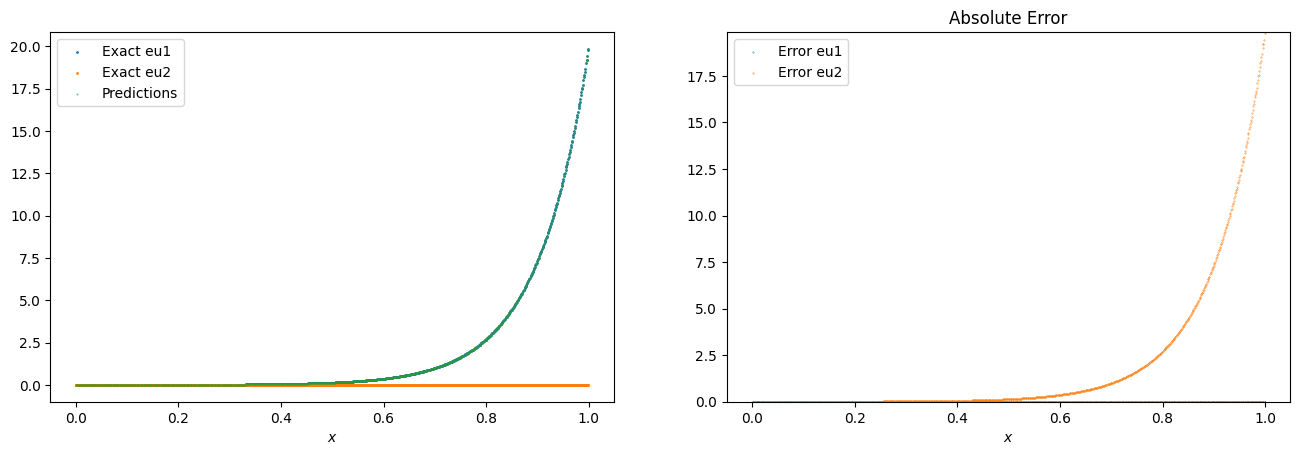

In [ ]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.3))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(x_test, u_test1, s=1.0, label="Exact eu1")
ax1.scatter(x_test, u_test2, s=1.0, label="Exact eu2")
ax1.scatter(x_test, u_pred, s=0.1, label="Predictions")
ax1.set_xlabel("$x$")
ax1.legend()

#===============
# Second subplot
#===============
# set up the axes for the second plot

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(x_test, error1, s=0.1, label="Error eu1")
ax2.scatter(x_test, error2, s=0.1, label="Error eu2")
ax2.set_ylim(0.0, np.max([error1.max(), error2.max()]))
ax2.set_xlabel("$x$")
ax2.set_title('Absolute Error')
ax2.legend()

plt.show()

